# Replicating ResNet paper: Deep Residual Learning for Image Recognition

## Preparing the data

The data that will be used is ImageNet 100: (per class)
* 1300 **train** images
* 100 **val** images


In [ ]:
BATCH_SIZE = 1
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
train_dir = "../ImageNet100/train.X"
val_dir   = "../ImageNet100/val.X/"

In [ ]:
import keras
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
)

2024-08-10 20:50:44.289435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 20:50:44.289488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 20:50:44.290443: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 20:50:44.294667: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 20:50:44.945389: W tensorflow/compiler/tf2

Found 130000 files belonging to 100 classes.


2024-08-10 20:50:49.564696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-10 20:50:49.586024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-10 20:50:49.589457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 5000 files belonging to 100 classes.


In [ ]:
class_names = train_ds.class_names
class_names[:10]

['American alligator, Alligator mississipiensis',
 'American coot, marsh hen, mud hen, water hen, Fulica americana',
 'Dungeness crab, Cancer magister',
 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis',
 'agama',
 'albatross, mollymawk',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'banded gecko',
 'barn spider, Araneus cavaticus']

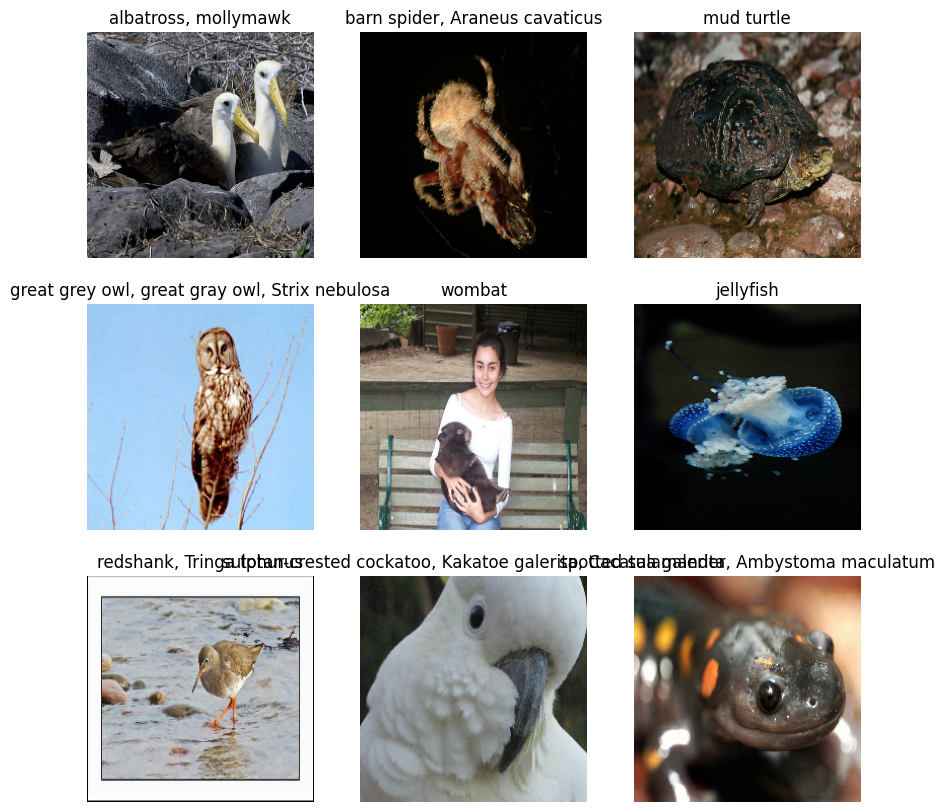

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [ ]:
normalization_layer = keras.layers.Rescaling(1./255)

In [ ]:
train_norm_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
val_norm_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
import numpy as np

image_batch, labels_batch = next(iter(train_norm_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9868471


In [ ]:
import tensorflow as tf
train_norm_ds = train_norm_ds.prefetch(tf.data.AUTOTUNE)
val_norm_ds = val_norm_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
train_norm_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Building residual layer

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense, Input, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.activations import relu, softmax
from keras.optimizers import Adam
from keras.losses import mae

In [ ]:
dummy_tensor = tf.range(-5, 5)
keras.activations.relu(dummy_tensor)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 1, 2, 3, 4], dtype=int32)>

In [ ]:
class ResidualLayer(keras.layers.Layer):
    def __init__(self, list_neurons:list[int, int, int],  **kwargs):
        super().__init__(**kwargs)
        self.n_a, self.n_b, self.n_c = list_neurons

        self.conv2a = Conv2D(self.n_a, 1, activation='relu')
        self.norm_a = BatchNormalization()

        self.conv2b = Conv2D(self.n_b, 3, padding="same", activation='relu')
        self.norm_b = BatchNormalization()

        self.conv2c = Conv2D(self.n_c, 1, activation='relu')
        self.norm_c = BatchNormalization()

        self.conv2add = Conv2D(self.n_c, 1, padding="same", activation='relu')

    def call(self, inputs, training=False):
        x = self.conv2a(inputs)
        x = self.norm_a(x, training=training)
        x = relu(x)

        x = self.conv2b(x)
        x = self.norm_b(x, training=training)
        x = relu(x)

        x = self.conv2c(x)
        x = self.norm_c(x, training=training)

        x += self.conv2add(inputs)

        return relu(x)

## Creating a 50-layer model

In [ ]:
keras.backend.clear_session()

In [ ]:
with tf.device("cpu:0"):
    model_input = Input((224, 224, 3), dtype=tf.float32)

    conv_2x = Conv2D(64, 7, strides=2, activation='relu')(model_input)
    maxpool_x = MaxPooling2D((3, 3), strides=2)(conv_2x)

    residual_1a = ResidualLayer([64, 64, 256], name="1_a")(maxpool_x)
    residual_1b = ResidualLayer([64, 64, 256], name="1_b")(residual_1a)
    residual_1c = ResidualLayer([64, 64, 256], name="1_c")(residual_1b)

    residual_2a = ResidualLayer([128, 128, 512], name="2_a")(residual_1c)
    residual_2b = ResidualLayer([128, 128, 512], name="2_b")(residual_2a)
    residual_2c = ResidualLayer([128, 128, 512], name="2_c")(residual_2b)
    residual_2d = ResidualLayer([128, 128, 512], name="2_d")(residual_2c)

    residual_3a = ResidualLayer([256, 256, 1024], name="3_a")(residual_2d)
    residual_3b = ResidualLayer([256, 256, 1024], name="3_b")(residual_3a)
    residual_3c = ResidualLayer([256, 256, 1024], name="3_c")(residual_3b)
    residual_3d = ResidualLayer([256, 256, 1024], name="3_d")(residual_3c)
    residual_3e = ResidualLayer([256, 256, 1024], name="3_e")(residual_3d)
    residual_3f = ResidualLayer([256, 256, 1024], name="3_f")(residual_3e)

    # residual_4a = ResidualLayer([512, 512, 2048], name="4_a")(residual_3f)
    # residual_4b = ResidualLayer([512, 512, 2048], name="4_b")(residual_4a)
    # residual_4c = ResidualLayer([512, 512, 2048], name="4_c")(residual_4b)

    avg_pool    = AveragePooling2D(name="5")(residual_3e)
    flatten      = Flatten()(avg_pool)
    print(flatten.shape)
    model_output = Dense(100, activation='softmax')(flatten)

    print(model_output.shape)
    model = keras.Model(model_input, model_output)

(None, 746496)
(None, 100)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics="accuracy")

In [ ]:
model.output_shape

(None, 100)

In [ ]:
test_input = list(train_norm_ds.take(1))[0][0]
test_input.shape
test_output = list(train_norm_ds.take(1))[0][1]
test_output

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([32, 99, 17, 46,  8, 70, 66, 62, 21, 99, 27, 22, 43, 95, 68, 93, 87,
       18, 30, 71, 82, 78, 64, 85, 54, 75, 99, 26,  8, 36, 63, 76],
      dtype=int32)>

In [ ]:
model.fit(test_input, test_output, epochs=10, verbose=1)

Epoch 1/10


2024-08-10 20:51:01.001823: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-10 20:51:01.065202: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-10 20:51:03.831831: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 676.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-10 20:51:04.123574: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 676.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-10 20:51:05.237421: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) r

ResourceExhaustedError: Graph execution error:

Detected at node model/2_b/conv2d_19/Conv2D defined at (most recent call last):
  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2854/4284980487.py", line 1, in <module>

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/tmp/ipykernel_2854/4142141883.py", line 26, in call

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

Detected at node model/2_b/conv2d_19/Conv2D defined at (most recent call last):
  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2854/4284980487.py", line 1, in <module>

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/tmp/ipykernel_2854/4142141883.py", line 26, in call

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/lolka0d/anaconda3/envs/tensorflow2.15/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,512,54,54] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/2_b/conv2d_19/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[model/2_d/batch_normalization_18/FusedBatchNormV3/_450]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,512,54,54] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/2_b/conv2d_19/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_18644]

In [ ]:
model.evaluate(test_input, test_output)

1/1 [==============================] - 13s 13s/step - loss: 4.6052 - accuracy: 0.0000e+00


[4.6052045822143555, 0.0]

In [ ]:
cccc = test_input
cccc = layer(cccc)
cccc.shape

ValueError: Exception encountered when calling layer '1_2' (type ResidualLayer).

Input 0 of layer "conv2d_853" is incompatible with the layer: expected axis -1 of input shape to have value 256, but received input with shape (32, 224, 224, 3)

Call arguments received by layer '1_2' (type ResidualLayer):
  • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)
  • training=False